# Amazon Alexa Sentiment Analysis

## Introduction
This project aims to analyze the Amazon Alexa dataset and build classification models to predict whether the sentiment of a given input sentence is positive or negative.

## Table of Contents
1. [Import Libraries](#Import-Libraries)
2. [Data Loading and Exploration](#Data-Loading-and-Exploration)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Model Building](#Model-Building)
5. [Model Evaluation](#Model-Evaluation)
6. [Conclusion](#Conclusion)

##**Importing Required Libraries**

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%pip install wordcloud

##**Exploratory Data Analysis**

###Loading the Data
Load the dataset and examine its structure.

In [ ]:
# Load the dataset
data = pd.read_csv("/content/Data/amazon_alexa.tsv", delimiter='\t', quoting=3)

# Display dataset shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()


Dataset shape: (3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


###Checking for Null Values

Identify and handle any missing values in the dataset.

In [ ]:
# Check for null values
null_counts = data.isnull().sum()
print(null_counts)

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


In [ ]:
# Drop records with null values
data.dropna(inplace=True)
print(f"Dataset shape after dropping null values: {data.shape}")

Dataset shape after dropping null values: (3149, 5)


###Adding a Length Column

Create a new column to store the length of each review for additional analysis.

In [ ]:
# Create 'length' column
data['length'] = data['verified_reviews'].apply(len)
data.head()


,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


###Data Types

Check the data types of each column to understand the structure better.

In [ ]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

###Analyzing the Rating Column

Analyze the distribution of ratings in the dataset.

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


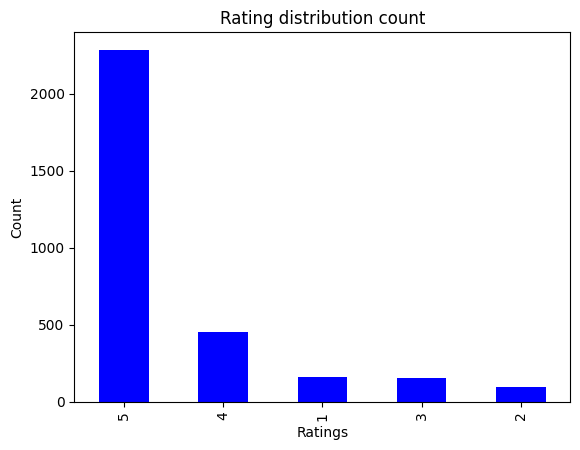

In [ ]:
# Rating distribution
print(f"Rating value count: \n{data['rating'].value_counts()}")

# Bar plot of rating distribution
data['rating'].value_counts().plot.bar(color='blue')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [ ]:
# Percentage distribution of each rating
print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100, 2)}")


Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


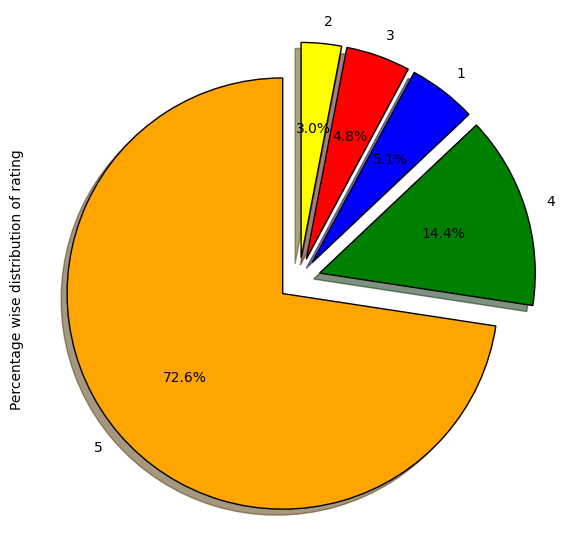

In [ ]:
# Pie chart of rating distribution
fig = plt.figure(figsize=(7, 7))
colors = ('orange', 'green', 'blue', 'red', 'yellow')
wp = {'linewidth': 1, "edgecolor": 'black'}
tags = data['rating'].value_counts() / data.shape[0]
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distribution of rating')
plt.show()

###Analyzing the Feedback Column

Examine the feedback column to understand the sentiment distribution.

In [ ]:
# Feedback distribution
print(f"Feedback value count: \n{data['feedback'].value_counts()}")


Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [ ]:
# Examples of reviews for feedback 0 and 1
review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(f"Example negative review: {review_0}")
print(f"Example positive review: {review_1}")

Example negative review: Sound is terrible if u want good music too get a bose
Example positive review: Loved it!


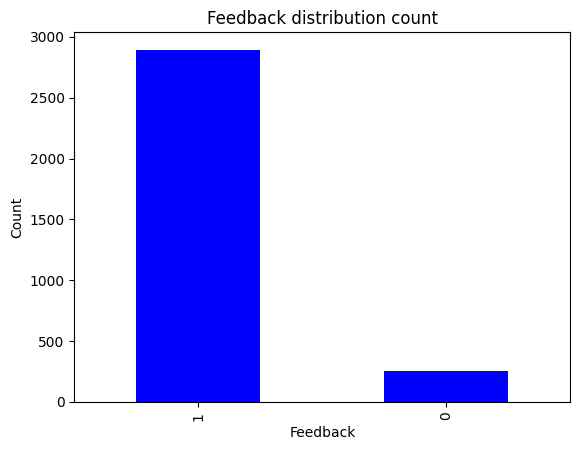

In [ ]:
# Bar plot of feedback distribution
data['feedback'].value_counts().plot.bar(color='blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()


In [ ]:
# Percentage distribution of feedback
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100, 2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


###Analyzing the Variation Column

Explore the variation column to see the different types of Amazon Alexa products.

In [ ]:
# Variation distribution
print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


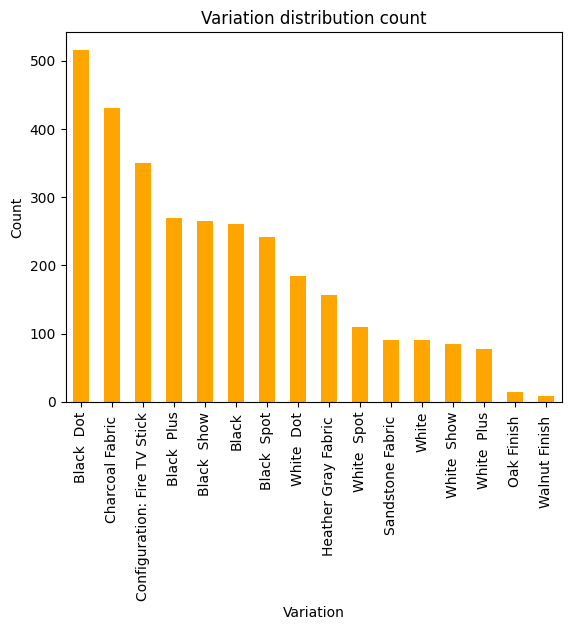

In [ ]:
# Bar plot of variation distribution
data['variation'].value_counts().plot.bar(color='orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [ ]:
# Percentage distribution of variation
print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100, 2)}")


Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64


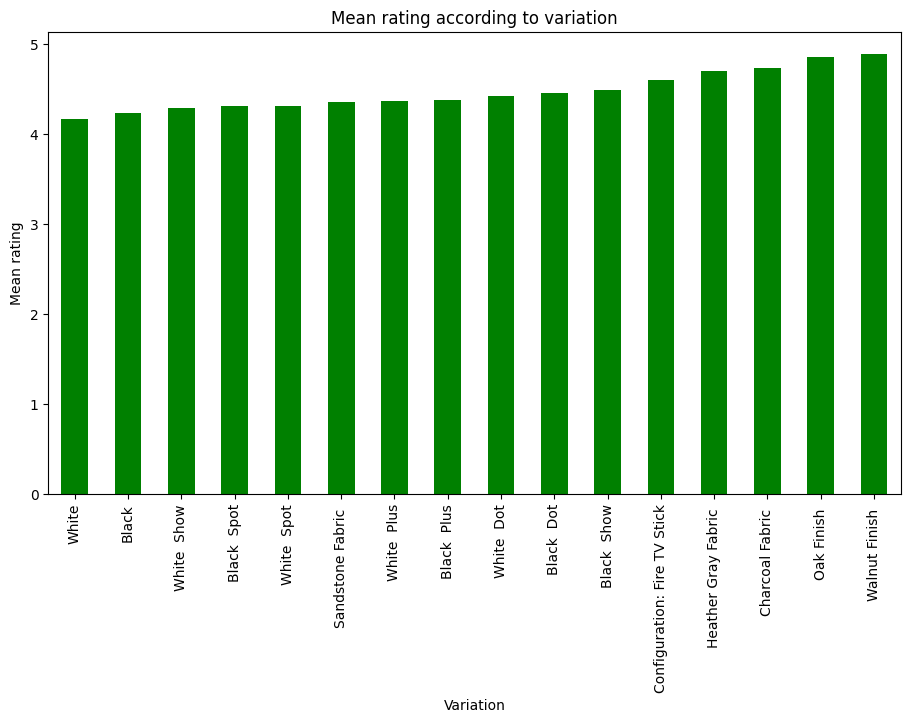

In [ ]:
# Mean rating by variation
mean_ratings = data.groupby('variation')['rating'].mean()
print(mean_ratings)
mean_ratings.sort_values().plot.bar(color='green', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

###Analyzing the Verified Reviews Column

Examine the length of reviews and their distribution.

In [ ]:
# Length analysis
print(data['length'].describe())

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64


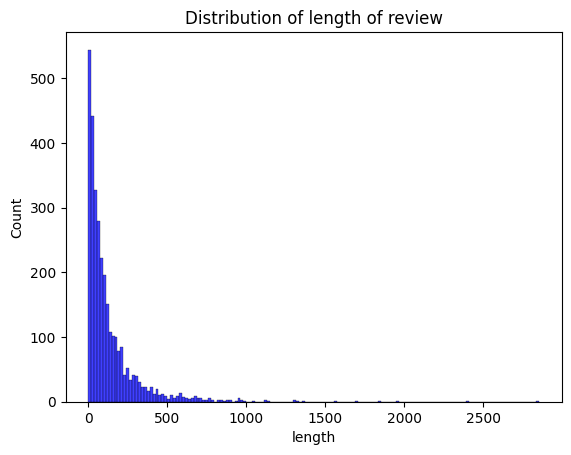

In [ ]:
# Histogram of review lengths
sns.histplot(data['length'], color='blue').set(title='Distribution of length of review')
plt.show()

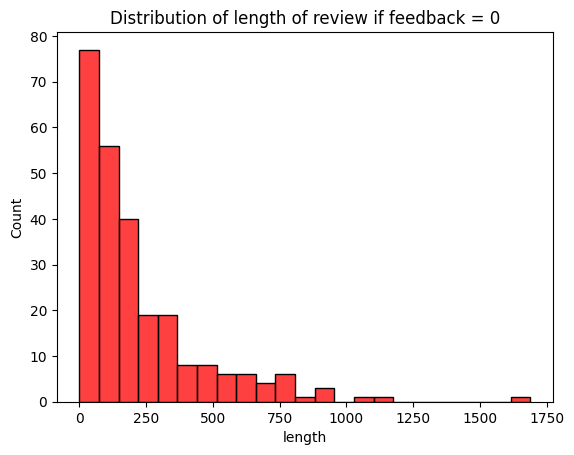

In [ ]:
# Histogram of review lengths for negative feedback
sns.histplot(data[data['feedback'] == 0]['length'], color='red').set(title='Distribution of length of review if feedback = 0')
plt.show()

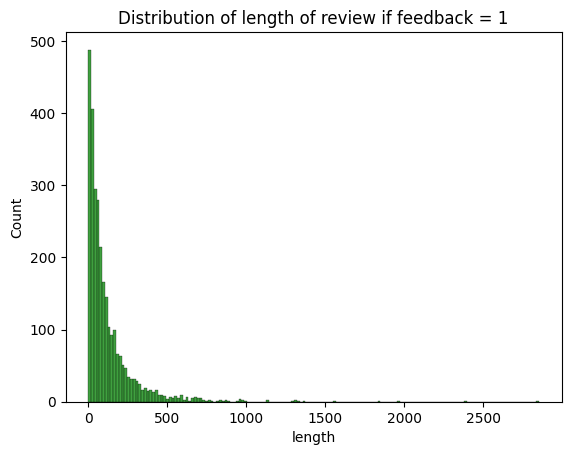

In [ ]:
# Histogram of review lengths for positive feedback
sns.histplot(data[data['feedback'] == 1]['length'], color='green').set(title='Distribution of length of review if feedback = 1')
plt.show()

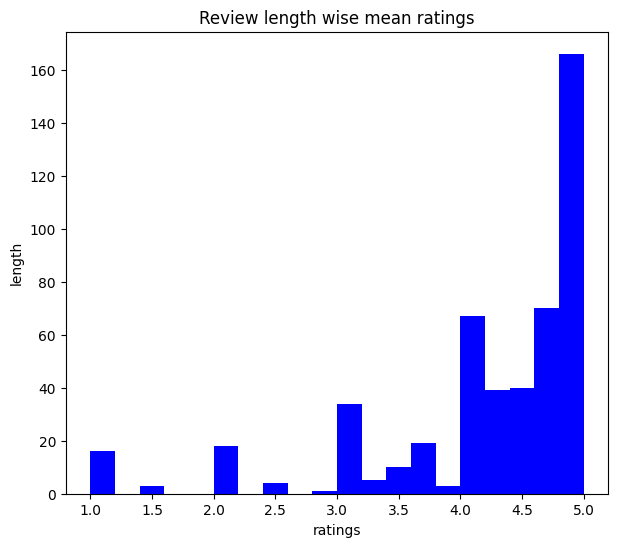

In [ ]:
# Length-wise mean rating
data.groupby('length')['rating'].mean().plot.hist(color='blue', figsize=(7, 6), bins=20)
plt.title("Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

###Word Cloud

Generate word clouds to visualize common words in the reviews.

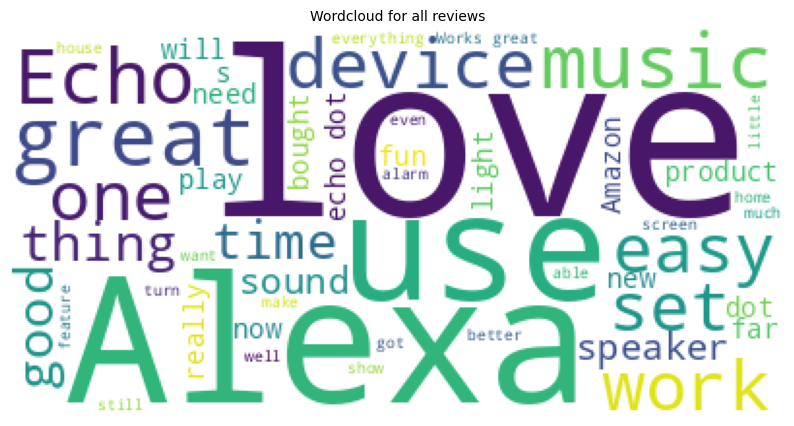

In [ ]:
# Word cloud for all reviews
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)
reviews = " ".join([review for review in data['verified_reviews']])
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
# Unique words in each feedback category
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']]).lower().split()
pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']]).lower().split()


In [ ]:
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_positive = [x for x in pos_reviews if x not in neg_reviews]

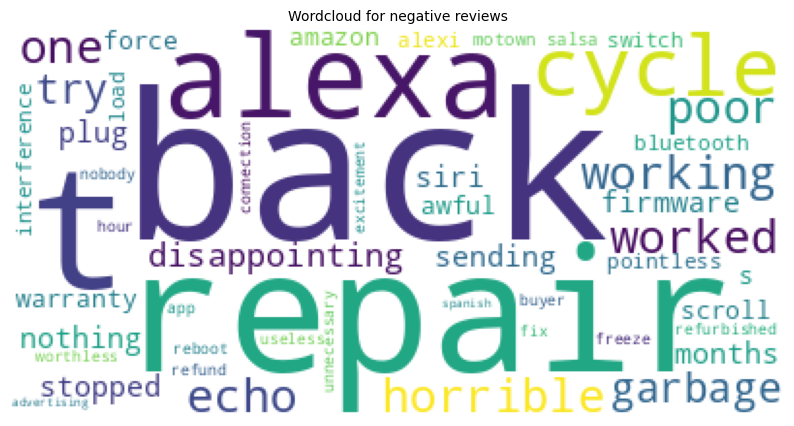

In [ ]:
# Word cloud for negative reviews
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(" ".join(unique_negative)))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

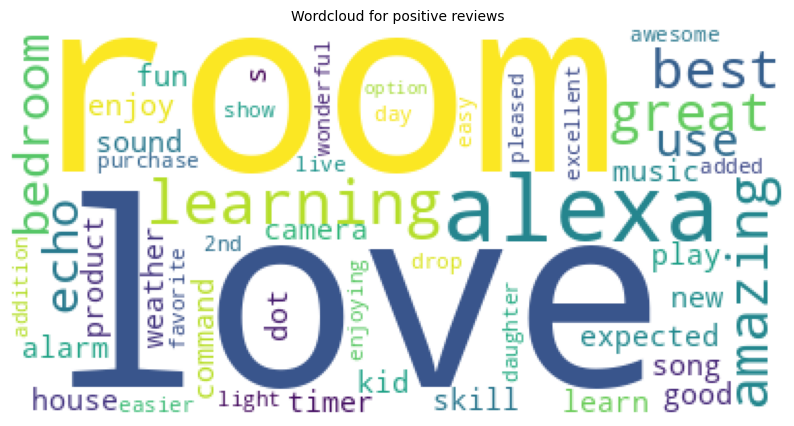

In [ ]:
# Word cloud for positive reviews
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(" ".join(unique_positive)))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

##**Preprocessing and Modelling**

###Text Preprocessing

Perform text preprocessing including removing non-alphabetic characters, converting to lowercase, and stemming.

In [ ]:
# Text preprocessing
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)


###Vectorization

Convert the corpus into a bag-of-words model using CountVectorizer.

In [ ]:
# Bag of words creation
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

# Save the Count Vectorizer model
pickle.dump(cv, open('/content/Data/countVectorizer.pkl', 'wb'))

# Check the shape of X and y
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (3149, 2500)
y shape: (3149,)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2500)

# Transform the corpus using TF-IDF vectorization
X = tfidf_vectorizer.fit_transform(corpus).toarray()
y = data['feedback'].values

# Save the TF-IDF vectorizer model
pickle.dump(cv, open('/content/Data/tfidfVectorizer.pkl', 'wb'))

# Check the shape of X and y
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


##**Train-Test Split**

Split the dataset into training and testing sets.

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")


X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)
X train max value: 1.0
X test max value: 1.0


###Feature Scaling

Scale the features to bring all values between 0 and 1.

In [ ]:
# Feature scaling
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

# Save the scaler model
pickle.dump(scaler, open('/content/Data/scaler.pkl', 'wb'))


##**Random Forest Classifier**

Train and evaluate a Random Forest classifier.

In [ ]:
# Train Random Forest model
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [ ]:
# Model accuracy
print("Training Accuracy:", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy:", model_rf.score(X_test_scl, y_test))

Training Accuracy: 0.9945553539019963
Testing Accuracy: 0.9417989417989417


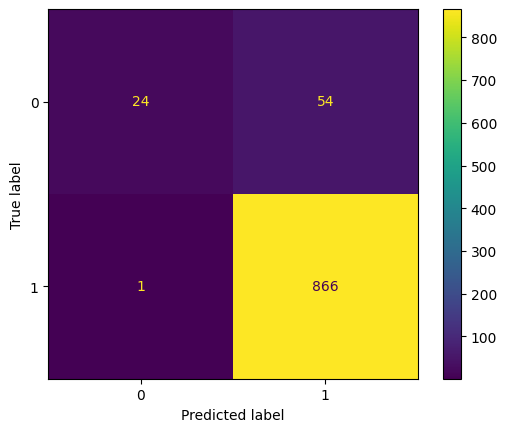

In [ ]:
# Predictions and confusion matrix
y_preds = model_rf.predict(X_test_scl)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()


In [ ]:
# K-fold cross-validation
accuracies = cross_val_score(estimator=model_rf, X=X_train_scl, y=y_train, cv=10)
print("Accuracy:", accuracies.mean())
print("Standard Deviation:", accuracies.std())

Accuracy: 0.9301316330728095
Standard Deviation: 0.007333404704379681


In [ ]:
# Grid search for optimal parameters
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}
cv_object = StratifiedKFold(n_splits=2)
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv=cv_object, verbose=0, return_train_score=True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [ ]:
# Best parameters
print("Best Parameter Combination:", grid_search.best_params_)
print("Cross validation mean accuracy on train set:", grid_search.cv_results_['mean_train_score'].mean() * 100)
print("Cross validation mean accuracy on test set:", grid_search.cv_results_['mean_test_score'].mean() * 100)
print("Accuracy score for test set:", accuracy_score(y_test, y_preds))


Best Parameter Combination: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}
Cross validation mean accuracy on train set: 98.14541742286751
Cross validation mean accuracy on test set: 92.36615245009074
Accuracy score for test set: 0.9417989417989417


In [ ]:
# Save the RF model
pickle.dump(model_rf, open('/content/Data/model_rf.pkl', 'wb'))

##**XGBoost Classifier**
Train and evaluate an XGBoost classifier

In [ ]:
# Train XGBoost model
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Model accuracy
print("Training Accuracy:", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy:", model_xgb.score(X_test_scl, y_test))

Training Accuracy: 0.9818511796733213
Testing Accuracy: 0.9407407407407408


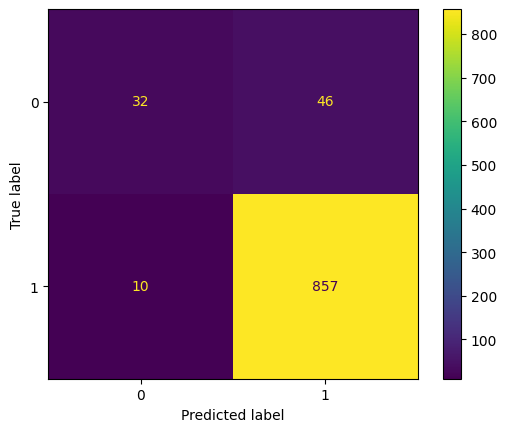

In [ ]:
# Predictions and confusion matrix
y_preds = model_xgb.predict(X_test_scl)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [ ]:
# Save the XGBoost model
pickle.dump(model_xgb, open('/content/Data/model_xgb.pkl', 'wb'))

##**Decision Tree Classifier**
Train and evaluate a Decision Tree classifier.

In [ ]:
# Train Decision Tree model
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [ ]:
# Model accuracy
print("Training Accuracy:", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy:", model_dt.score(X_test_scl, y_test))


Training Accuracy: 0.9945553539019963
Testing Accuracy: 0.9206349206349206


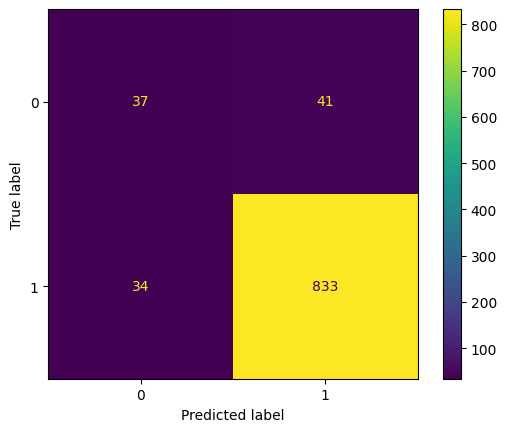

In [ ]:
# Predictions and confusion matrix
y_preds = model_dt.predict(X_test_scl)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

##**Summary**

This project includes loading and preprocessing data, exploratory data analysis, text preprocessing, and building and evaluating machine learning models for sentiment analysis. By using Random Forest, XGBoost, and Decision Tree classifiers, we can predict whether a review is positive or negative with a good degree of accuracy. Each step includes detailed analysis and visualization to ensure comprehensive understanding and effective model building.